# Truss Analysis Examples

This notebook demonstrates the usage of the `TrussAnalysis` library to solve non-linear truss problems. We will analyze the "Inclined Axial Rod" example from Bonet & Wood, Chapter 3, considering both Elastic and Elasto-Plastic material behavior.

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from truss_analysis import TrussAnalysis, TrussElement


# Helper function to run a simulation
def run_simulation(sig_y0_val, label):
    print(f"Running simulation: {label}")
    nodes = [[0.0, 0.0], [100.0, 100.0]]
    E = 210000.0
    A = 1.0
    H = 1.0

    analysis = TrussAnalysis(nodes)
    element = TrussElement(0, 1, E, A, sig_y0_val, H)
    analysis.add_element(element)

    # Boundary Conditions
    analysis.add_constraint(0, 0, 0.0)
    analysis.add_constraint(0, 1, 0.0)
    analysis.add_constraint(1, 0, 0.0)

    # Displacement Control
    steps = 100
    max_disp = -250.0
    displacements = np.linspace(0, max_disp, steps)

    res_force = []
    res_disp = []
    res_stress = []
    res_strain = []
    res_plastic_strain = []

    for disp in displacements:
        analysis.set_displacement(1, 1, disp)
        success, F_int = analysis.solve_step()

        if not success:
            print(f"Convergence failed at displacement {disp}")
            break

        # Reaction force (External Force = -Internal Force)
        fy = F_int[3]
        res_force.append(fy)
        res_disp.append(-disp)

        # Get element state
        _, _, _, tau, ep, eps = element.get_force_and_stiffness(analysis.current_nodes)
        res_stress.append(tau)
        res_plastic_strain.append(ep)
        res_strain.append(eps)

    return {
        "label": label,
        "disp": np.array(res_disp),
        "force": np.array(res_force),
        "stress": np.array(res_stress),
        "strain": np.array(res_strain),
        "plastic_strain": np.array(res_plastic_strain),
        "L0": element.L,
        "EA": E * A,
    }

## Run Simulations

We run two cases:
1.  **Elastic Case:** By setting a very high yield stress ($\sigma_{y0} = 10^{20}$), the material never yields.
2.  **Elasto-Plastic Case:** Using the realistic yield stress ($\sigma_{y0} = 25000$).

In [42]:
# Run Elastic Case
res_elastic = run_simulation(1e20, "Elastic")

# Run Elasto-Plastic Case
res_plastic = run_simulation(25000.0, "Elasto-Plastic")

Running simulation: Elastic
Running simulation: Elasto-Plastic


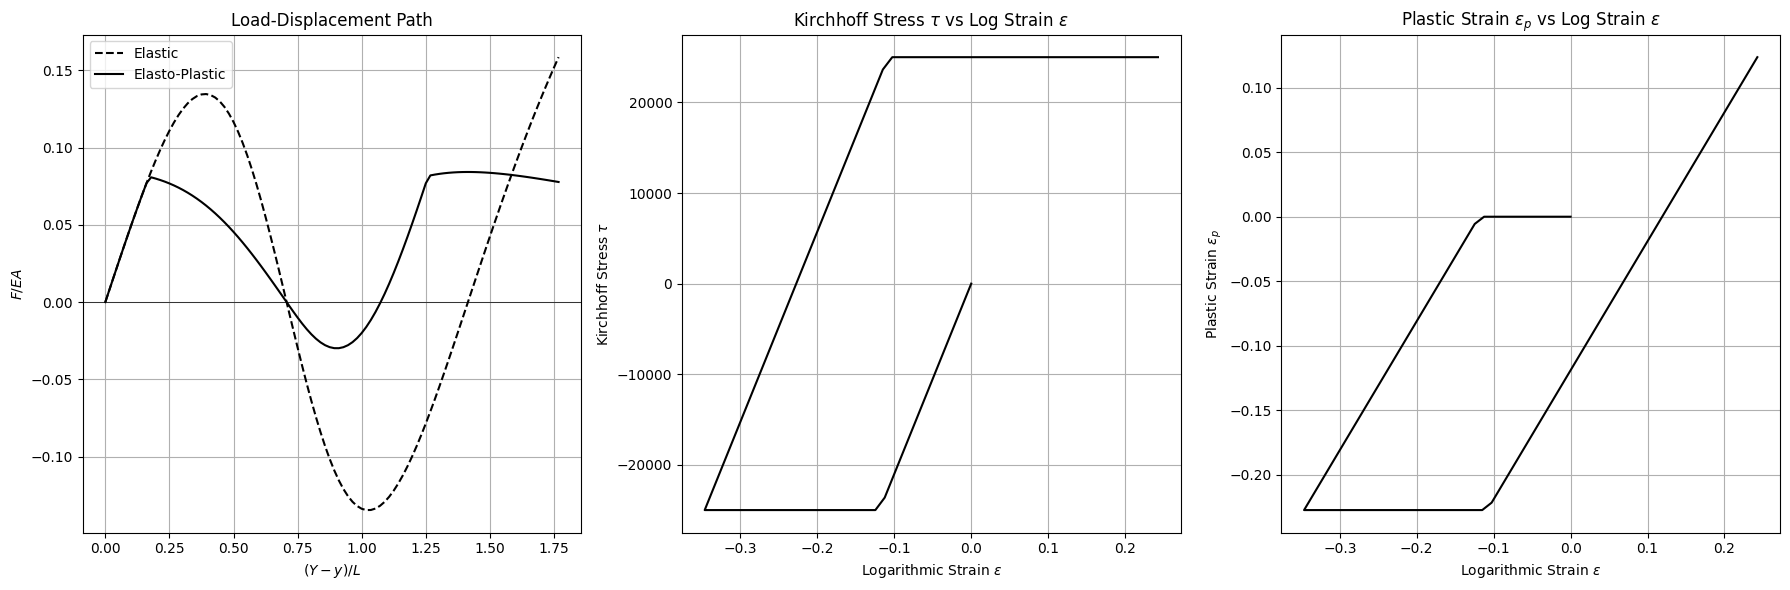

In [43]:
plt.figure(figsize=(18, 6))

# 1. Load-Displacement (Both)
plt.subplot(1, 3, 1)

# Plot Elastic
x_el = res_elastic["disp"] / res_elastic["L0"]
y_el = -res_elastic["force"] / res_elastic["EA"]
plt.plot(x_el, y_el, "k--", label=res_elastic["label"])

# Plot Plastic
x_pl = res_plastic["disp"] / res_plastic["L0"]
y_pl = -res_plastic["force"] / res_plastic["EA"]
plt.plot(x_pl, y_pl, "k-", label=res_plastic["label"])

plt.title("Load-Displacement Path")
plt.xlabel(r"$(Y-y)/L$")
plt.ylabel(r"$F / EA$")
plt.grid(True)
plt.legend()
plt.axhline(0, color="k", linewidth=0.5)

# 2. Tau vs Epsilon (Plastic Case)
plt.subplot(1, 3, 2)
plt.plot(res_plastic["strain"], res_plastic["stress"], "k-")
plt.title(r"Kirchhoff Stress $\tau$ vs Log Strain $\varepsilon$")
plt.xlabel(r"Logarithmic Strain $\varepsilon$")
plt.ylabel(r"Kirchhoff Stress $\tau$")
plt.grid(True)

# 3. Epsilon_p vs Epsilon (Plastic Case)
plt.subplot(1, 3, 3)
plt.plot(res_plastic["strain"], res_plastic["plastic_strain"], "k-")
plt.title(r"Plastic Strain $\varepsilon_p$ vs Log Strain $\varepsilon$")
plt.xlabel(r"Logarithmic Strain $\varepsilon$")
plt.ylabel(r"Plastic Strain $\varepsilon_p$")
plt.grid(True)

plt.tight_layout()
plt.savefig("truss_elasto_plastic_analysis.pdf")
plt.show()

## 3.6.2 Trussed Frame Example

This example demonstrates the analysis of a trussed frame structure (Figure 3.9). The structure is an L-shaped frame modeled with truss elements. It is loaded with a vertical force at Node 144.

We will analyze:
1.  **Elastic Case**: Exhibits snap-back behavior (requires Arc-Length control to trace fully, but we will simulate the loading path).
2.  **Elasto-Plastic Case**: Shows the reduction in maximum load due to plasticity.
3.  **Clamped Supports**: The same frame with clamped 

**Note:** The Elastic case with snap-back (displacement reversal) cannot be fully traced with standard displacement control.


In [44]:
import importlib
import lee_frame

importlib.reload(lee_frame)
from lee_frame import (
    run_frame_simulation,
    build_analysis_from_flagshyp,
    FLAGSHYP_TRUSS_ELASTIC,
    FLAGSHYP_TRUSS_PLASTIC,
)

d_el, f_el, analysis_el, hist_el = run_frame_simulation(
    "Elastic",
    clamped=False,
    method="arc_length",
    record_history=True,
    input_path=FLAGSHYP_TRUSS_ELASTIC,
    use_control=True,
    adaptive_ds=False,
)
d_pl, f_pl, analysis_pl, hist_pl = run_frame_simulation(
    "Plastic",
    clamped=False,
    method="arc_length",
    record_history=True,
    input_path=FLAGSHYP_TRUSS_PLASTIC,
    use_control=True,
    target_disp=32.0,
    max_steps=400,
)


Running Frame Simulation: Elastic, Clamped=False, Method=arc_length
Arc-Length failed near step 0
Running Frame Simulation: Plastic, Clamped=False, Method=arc_length
Arc-Length failed near step 0


/tmp/ipykernel_9076/2974343511.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


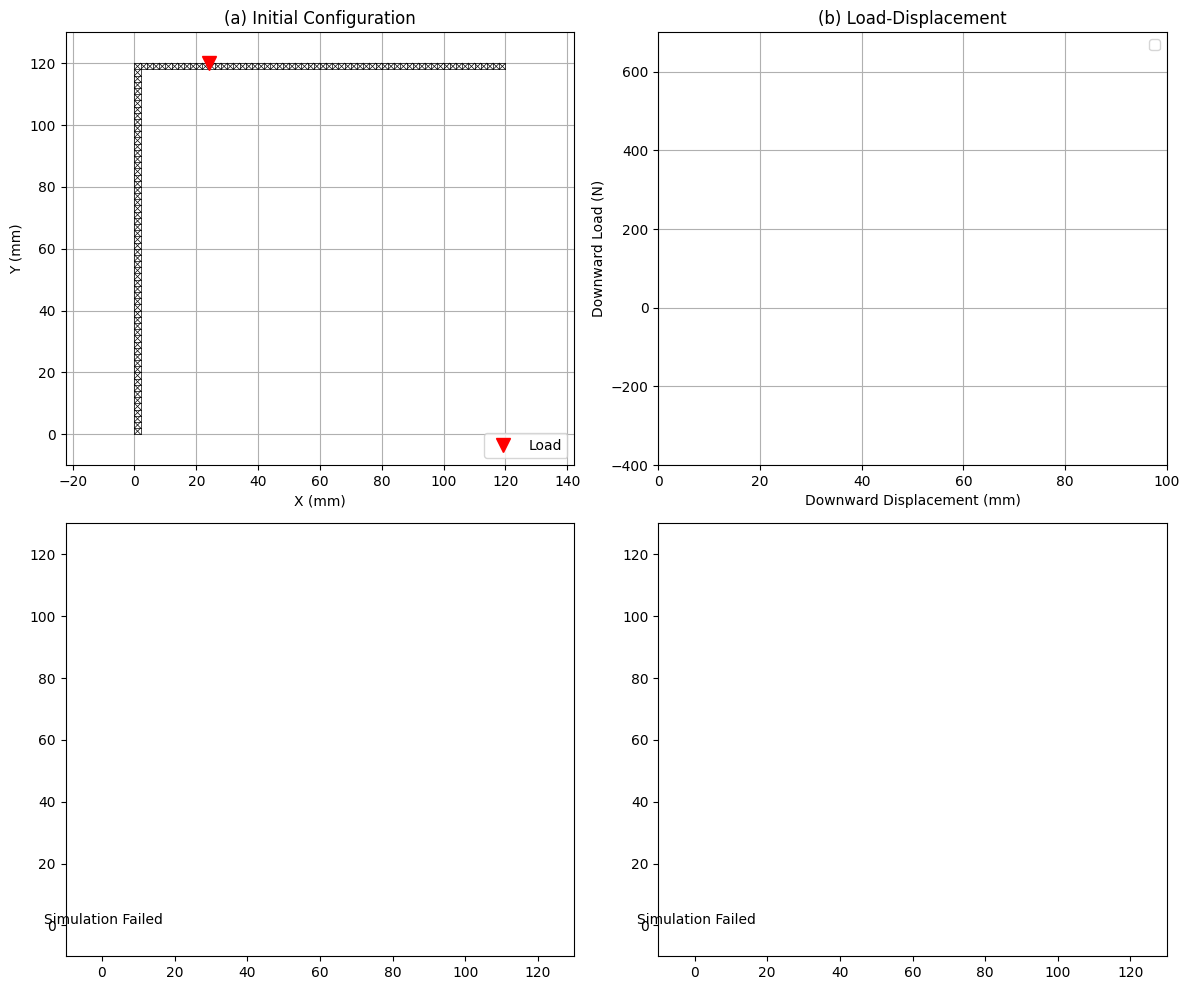

In [45]:
plt.figure(figsize=(12, 10))

from lee_frame import (
    select_snapshot_indices,
    plot_truss_on_axis,
    build_analysis_from_flagshyp,
    FLAGSHYP_TRUSS_ELASTIC,
)

# (a) Initial Configuration
plt.subplot(2, 2, 1)
analysis_initial, load_node_idx, _, _ = build_analysis_from_flagshyp(
    FLAGSHYP_TRUSS_ELASTIC, clamped=False
)
plot_truss_on_axis(
    plt.gca(),
    analysis_initial,
    "(a) Initial Configuration",
    style="k-",
)
# Mark load node
ln = analysis_initial.nodes[load_node_idx]
plt.plot(ln[0], ln[1], "rv", markersize=10, label="Load")
plt.legend()
plt.gca().set_xlim(-10, 130)
plt.gca().set_ylim(-10, 130)

# (b) Load-Displacement Curves
plt.subplot(2, 2, 2)
if len(d_el) > 0:
    plt.plot(d_el, -f_el, "k--", label="Elastic")
if len(d_pl) > 0:
    plt.plot(d_pl, -f_pl, "k-", label="Plastic")

plt.title("(b) Load-Displacement")
plt.xlabel("Downward Displacement (mm)")
plt.ylabel("Downward Load (N)")
plt.legend()
plt.grid(True)
plt.xlim(0, 100)
plt.ylim(-400, 700)

# (c) Deformed State (Elastic)
plt.subplot(2, 2, 3)
if len(d_el) > 0 and hist_el:
    elastic_targets = [(21.0, 402.0), (50.0, 556.0), (58.0, -285.0), (94.0, 592.0)]
    elastic_indices = select_snapshot_indices(d_el, -f_el, elastic_targets)
    for idx in elastic_indices:
        plot_truss_on_axis(
            plt.gca(), analysis_el, "", style="k-", nodes_override=hist_el[idx]
        )
    plt.title("(c) Deformed Elastic (snapshots)")
else:
    plt.text(0.5, 0.5, "Simulation Failed", ha="center")
plt.gca().set_xlim(-10, 130)
plt.gca().set_ylim(-10, 130)

# (d) Deformed State (Plastic)
plt.subplot(2, 2, 4)
if len(d_pl) > 0 and hist_pl:
    plastic_targets = [(32.0, 222.0)]
    plastic_indices = select_snapshot_indices(d_pl, -f_pl, plastic_targets)
    idx = plastic_indices[0] if plastic_indices else -1
    plot_truss_on_axis(
        plt.gca(),
        analysis_pl,
        "(d) Deformed Plastic (snapshot)",
        style="k-",
        nodes_override=hist_pl[idx],
    )
else:
    plt.text(0.5, 0.5, "Simulation Failed", ha="center")
plt.gca().set_xlim(-10, 130)
plt.gca().set_ylim(-10, 130)

plt.tight_layout()
plt.show()
